In [132]:
# noiseprint/Inference/Inference.py

import os, sys, random, warnings, argparse, cv2, json
sys.path.append('../')
sys.path.append('/home/jiwon/anaconda3/envs/intern2/lib/python3.8/site-packages/')

import dlib
face_detector = dlib.get_frontal_face_detector()

import utils as ut
import numpy as np
import pandas as pd
import multiprocessing as mp
warnings.filterwarnings('ignore')

from sys import argv
from time import time
from PIL import Image
from PIL.JpegImagePlugin import convert_dict_qtables
from os.path import join
from os import cpu_count
from multiprocessing.pool import Pool
from collections import OrderedDict
from glob import glob
from tqdm import tqdm 
from functools import partial 

# for interactive plot
# If you use this option, plot will appear at first-drawn position
import matplotlib #%matplotlib notebook
import matplotlib.pyplot as plt
%matplotlibe inline
plt.style.use('ggplot') # You can also use different style

from sklearn.decomposition import NMF # Use this for training Non-negative Matrix Factorization
from sklearn.utils.extmath import randomized_svd # Use this for training Singular Value Dec
from sklearn.manifold import TSNE # Use this for training t-sne manifolding
# import mplcursors # Use this is for creating a cursor-interactive plot with "%matplotlib notebook"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.models as models
from torchvision import transforms as T

UsageError: Line magic function `%matplotlibe` not found.


# Read One Video 
1. Get face area for one frame 
2. Get every frames in the Dateset - Dataloader
3. Get noiseprint per every frames 

In [133]:
ROOT_DIR = '/media/data2/jiwon/CSIRO/'
root_dir = os.listdir(ROOT_DIR)
print(root_dir[:])

VIDEO_DIR = join(ROOT_DIR, '0115/fs')
video_dir = os.listdir(VIDEO_DIR)
print(video_dir[:])

result_dir = join(ROOT_DIR, 'Inference')
# result_dir = os.listdir(result_dir)
print(result_dir[:])

['0519', '0716', '0308', '0818', 'Inference', '0225', '0424', '0609', '0115']
['15__walk_down_hall_angry_converted_6.mp4', '15__walk_down_hall_angry_converted_7.mp4']
/media/data2/jiwon/CSIRO/Inference


# Bring noiseprint extractor

- apply Tensor transform to image for insert it to model.

In [134]:
model_ = torch.load('/media/data2/jiwon/noiseprint/save/e200s10/snapshot.pt')
model = ut.DnCNN()
model.load_state_dict(model_['MODEL_STATE'])

<All keys matched successfully>

In [135]:
temp_name = '/media/data2/jiwon/CSIRO/Inference/15__walk_down_hall_angry_converted_6/frame/0000.png'
temp = cv2.imread(temp_name)
tf = T.ToTensor()
tensor_temp = tf(temp).unsqueeze(0)
print(tensor_temp.shape)
out, o_i, i_o = model(tensor_temp)
print(out.shape, o_i.shape, i_o.shape)

torch.Size([1, 3, 1080, 1920])
torch.Size([1, 1, 1080, 1920]) torch.Size([1, 3, 1080, 1920]) torch.Size([1, 3, 1080, 1920])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


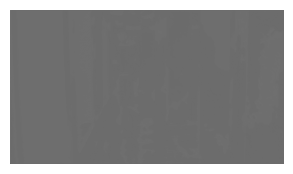

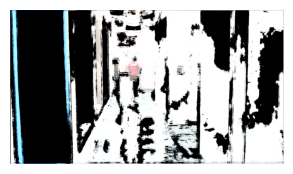

In [154]:
def show(tensor_img):
    np_img = np.transpose(tensor_img.squeeze(0).detach().numpy(), (1,2,0))
    plt.axis("off") # 축 제거
    plt.grid(False)
    plt.imshow(np_img, cmap='gray')
def show_sz(tensor_img):
    fig, ax = plt.subplots(figsize=(18, 2))
    np_img = np.transpose(tensor_img.squeeze(0).detach().numpy(), (1,2,0))

    ax.grid(False)
    plt.axis("off") # 축 제거
    ax.imshow(np_img, cmap='gray')
def show_np(img):
    plt.axis("off") # 축 제거
    plt.grid(False)
    plt.imshow(img, cmap='gray')
def show_np_size(img):
    fig, ax = plt.subplots(figsize=(18, 2))
    ax.grid(False)
    plt.axis("off") # 축 제거
    ax.imshow(img, cmap='gray')
# show(out)
show_sz(out)
# show_sz(o_i)
show_sz(i_o)

def save_tensor_img(tensor_img, dir, frame_num):
    np_img = np.transpose(tensor_img.squeeze(0).detach().numpy(), (1,2,0))
    tnp_save = join(dir, '{:04d}.png'.format(frame_num))
    cv2.imwrite(tnp_save, np_img)
    
save_tensor_img(out, '/media/data2/jiwon/CSIRO/Inference/15__walk_down_hall_angry_converted_6/noiseprint/', 0)

# Videoprints Generation 

In [141]:
def biggest_face_idx(faces):
    max_area = 0
    max_idx = 0
    for idx, face in enumerate(faces):
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()
        area_idx = (x2 - x1) * (y2 - y1)
        if area_idx > max_area:
            max_area = area_idx
            max_idx = idx
    return max_idx

def get_boundingbox(face, width, height, scale=1.3, minsize=None):
    """
    Expects a dlib face to generate a quadratic bounding box.
    :param face: dlib face class
    :param width: frame width
    :param height: frame height
    :param scale: bounding box size multiplier to get a bigger face region
    :param minsize: set minimum bounding box size
    :return: x, y, bounding_box_size in opencv form
    """
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale)
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

def read_video(file_name, folder_save, margin_scale=1.3):
    filename = join(VIDEO_DIR, file_name)
    print(filename)
    
    # if 'raw' in filename:
    face_locate = OrderedDict() 
    
    # 원본 프레임 이미지들을 저장할 폴더를 생성합시다.
    frame_dir = join(folder_save, 'frame')
    os.makedirs(frame_dir, exist_ok=True)
    face_dir = join(folder_save, 'face')
    os.makedirs(face_dir, exist_ok=True)
    noiseprint_dir = join(folder_save, 'noiseprint')
    os.makedirs(noiseprint_dir, exist_ok=True)
    
    # 영상에서 프레임들을 추출합시다.
    reader = cv2.VideoCapture(filename)
    frame_num = 0
    while reader.isOpened():
        success, image = reader.read()
        if not success:
            break
        if image is None:
            continue
        
        # 우선 원본 프레임 이미지를 저장해봅시다. 
        file_save = join(frame_dir, '{:04d}.png'.format(frame_num))
        cv2.imwrite(file_save, image)
        
        # 원본 프레임을 모델에 적용해봅시다. 텐서로 바꿔서 모델에 적용해보아요.
        tensor_img = tf(image).unsqueeze(0)
        out, o_i, i_o = model(tensor_img)
        save_tensor_img(out, noiseprint_dir, frame_num)
        
        # 이미지에 얼굴 영역을 추출해봅시다.
        height, width = image.shape[:2]
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_detector(gray, 1) # face_detector = dlib.get_frontal_face_detector()
        
        if len(faces):
            face_idx = 0 if len(faces)==1 else biggest_face_idx(faces)
            
            # For now only take biggest face
            face = faces[face_idx]
            x, y, size = get_boundingbox(face, width, height, scale=margin_scale)
            cropped_face = image[y:y+size, x:x+size]
            
            # 얼굴만 남기고 나머지 배경을 제거한 이미지를 생성해요.
            image[:y, :] = 0
            image[y+size:, :] = 0
            image[:, :x] = 0
            image[:, x+size:] = 0
            
            file_save = os.path.join(face_dir, '{:04d}.png'.format(frame_num))
            # if os.path.exists(file_save):
            #         continue
            success_ = False
            try: 
                cv2.imwrite(file_save, image)
                success_ = True
            except: pass
            if success_: face_locate[frame_num] = [x, y, size]
        frame_num += 1         
        #
        
    print('NUmber of frame counted: ', frame_num)           
    reader.release()       
    with open(os.path.join(folder_save, 'face_locate.json'), 'w') as outfile:
            json.dump(face_locate, outfile)
    return 1

def main_TransformImage(keyNames):
    try:
        for keyname in keyNames:
            
            # print(video_dir, keyname)
            video_name = keyname.split('/')[-1][:-4] # Not include '.mp4'
            # print(video_name)
            folder_save = join(result_dir, video_name)
            # print(folder_save)
            os.makedirs(folder_save, exist_ok=True)
            
            read_video(keyname, folder_save, margin_scale=1.3) 

        return "Reading Done!"
    except Exception as e:
        print(e)
        return "Reading Error!"
    
main_TransformImage(video_dir)

/media/data2/jiwon/CSIRO/0115/fs/15__walk_down_hall_angry_converted_6.mp4
NUmber of frame counted:  549
/media/data2/jiwon/CSIRO/0115/fs/15__walk_down_hall_angry_converted_7.mp4


KeyboardInterrupt: 

# Average of every noiseprint per frames.
: 모든 프레임 가져와서 픽셀별 평균 구하기

In [149]:
temp_dir = join(result_dir, '15__walk_down_hall_angry_converted_6')
temp_noise_dir = join(temp_dir, 'noiseprint')

noises = os.listdir(temp_noise_dir)

0281.png


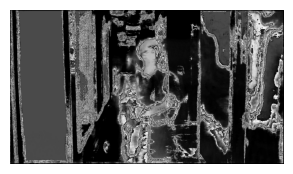

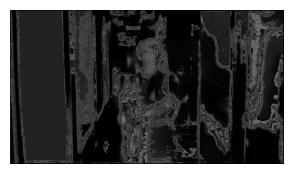

In [266]:
if len(noises) != 0:
    print(noises[0])
    first = cv2.imread(join(temp_noise_dir, noises[0]))
    height, width = first.shape[:2]
    sum_noise = np.zeros_like(first)
    sum_noise += first
    for i in range(1, len(noises)):
        n_noise = cv2.imread(join(temp_noise_dir, noises[i]))
        sum_noise += n_noise
    mean_noise =  sum_noise/len(noises)


def show_np(img):
    plt.axis("off") # 축 제거
    plt.grid(False)
    plt.imshow(img, cmap='gray')

show_np_size(sum_noise)
show_np_size(mean_noise)

In [292]:
def co_occurrence_Based_Local_Feature(mean_noise, q_step = 16): # high-pass filter 적용
    kernel = np.array([[-1,-1,-1,-1,8,-1,-1,-1,-1]], np.float32)
    residuals = cv2.filter2D(mean_noise, -1, kernel)

    # residuals quantization
    residuals_q = np.round(residuals / q_step).astype(int)

    # co-occurrences
    co_occurrences = np.zeros((16, 16, 16, 16))
    for i in range(mean_noise.shape[0]-3):
        for j in range(mean_noise.shape[1]):
            co_occurrences[residuals_q[i,j], residuals_q[i+1,j], residuals_q[i+3,j], residuals_q[i+3,j]] += 1

    # normalize and apply square-root non-linearity
    normalized_histogram = co_occurrences / co_occurrences.sum()
    feature_vector = np.sqrt(normalized_histogram).flatten()
    return feature_vector

# Merge with face mask

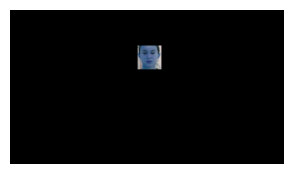

In [311]:
standard_face_idx = 400 #               '{:04d}.png'.format(frame_num))
temp_face_dir = join(temp_dir, 'face/{:04d}.png'.format(standard_face_idx))
standard_face = cv2.imread(temp_face_dir)
show_np_size(standard_face)

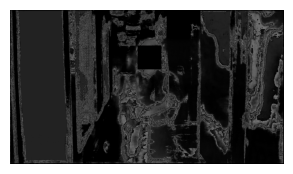

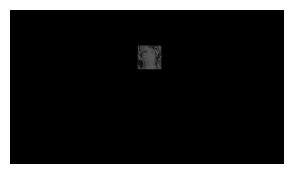

In [279]:
# sum_noise, standard_face

background_noiseprint = mean_noise.copy()
background_noiseprint[np.where(standard_face != 0)] = 0
show_np_size(background_noiseprint)

face_noiseprint = mean_noise.copy()
face_noiseprint[np.where(standard_face == 0)] = 0
show_np_size(face_noiseprint)

# Feature Extraction
1. background feature
2. face feature

HOG feature : Histogram of Oriented Gradients (이미지의 지역적인 그라디언트)
* Sobel filter -> gradients  


In [161]:
def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True, figsize = (8,8))
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

In [296]:
# print(background_noiseprint.shape)
# # Calculate the local gradient (using Sobel filters)
# bg_gx = cv2.Sobel(background_noiseprint, cv2.CV_64F, 1, 0)
# bg_gy = cv2.Sobel(background_noiseprint, cv2.CV_64F, 0, 1)

# bg_orientation_map = np.arctan2(bg_gx, bg_gy) * 180 / np.pi
# bg_orientation_map = np.abs(bg_orientation_map)
# bg_orientation_map = np.uint8(np.round(bg_orientation_map))
# # orientation_map = cv2.blur(orientation_map, (3, 3))

# plot_images(background_noiseprint, bg_gx, bg_gy, bg_orientation_map)

In [297]:
# print(face_noiseprint.shape)
# # Calculate the local gradient (using Sobel filters)
# fc_gx = cv2.Sobel(face_noiseprint, cv2.CV_64F, 1, 0)
# fc_gy = cv2.Sobel(face_noiseprint, cv2.CV_64F, 0, 1)

# fc_orientation_map = np.arctan2(fc_gx, fc_gy) * 180 / np.pi
# fc_orientation_map = np.abs(fc_orientation_map)
# fc_orientation_map = np.uint8(np.round(fc_orientation_map))
# # orientation_map = cv2.blur(orientation_map, (3, 3))

# plot_images(face_noiseprint, fc_gx, fc_gy, fc_orientation_map)

[0.09471767 0.09471767 0.09471767] float64 0.4644808743169399
(1080, 1920)


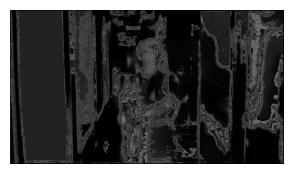

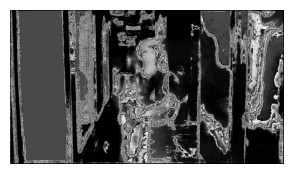

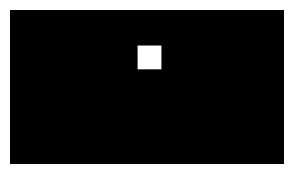

In [355]:
show_np_size(mean_noise)
print(mean_noise[0,0], mean_noise.dtype, np.amax(mean_noise))
# Check image depth and convert to uint8 if necessary
gray_img = np.mean(mean_noise* 255.0, axis=2).astype(np.uint8)
show_np_size(gray_img)
# Convert mask to binary
mask = cv2.threshold(face_noiseprint, 1, 255, cv2.THRESH_BINARY)[1][:,:,0]
show_np_size(mask)
print(mask.shape)

In [361]:

from scipy.stats import chi2
from sklearn.mixture import GaussianMixture
def splicebuster(image, mask_path=None, block_size=16, n_components=2, threshold=15, verbose=False):
    if mask_path:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 128).astype(np.uint8)
        image = cv2.bitwise_and(image, mask)
    # Compute feature vectors for each block
    feature_vectors = []
    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            block = image[i:i+block_size, j:j+block_size]
            cooc_mat = cv2.calcHist([block], [0], None, [256], [0, 256])
            cooc_mat /= cooc_mat.sum()
            feature_vectors.append(cooc_mat.flatten())
    feature_vectors = np.array(feature_vectors)
    # GMM clustering
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(feature_vectors)
    predicted_labels = gmm.predict(feature_vectors)
    # Compute Mahalanobis distance for each block
    mahalanobis_distances = []
    for i, feature_vector in enumerate(feature_vectors):
        mean = gmm.means_[predicted_labels[i]]
        covariance = gmm.covariances_[predicted_labels[i]]
        mahalanobis_distance = np.sqrt(np.dot(np.dot((feature_vector-mean).T, np.linalg.inv(covariance)), feature_vector-mean))
        mahalanobis_distances.append(mahalanobis_distance)
    mahalanobis_distances = np.array(mahalanobis_distances)
    # Compute chi-square distribution threshold
    chi_square_threshold = chi2.ppf(q=1-threshold/100, df=feature_vectors.shape[1])
    n_blocks_h = (image.shape[0] - 1) // block_size + 1
    n_blocks_w = (image.shape[1] - 1) // block_size + 1
    # Reshape predicted_labels and mahalanobis_distances back into the shape of the image
    predicted_labels = predicted_labels.reshape(n_blocks_h, n_blocks_w)
    mahalanobis_distances = mahalanobis_distances.reshape(n_blocks_h, n_blocks_w)
    # Apply threshold and generate output map
    output_map = np.zeros_like(predicted_labels, dtype=np.uint8)
    output_map[mahalanobis_distances > chi_square_threshold] = 255
    # Display output map if verbose=True
    if verbose:
        cv2.imshow("Output Map", output_map)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return output_map, mahalanobis_distances, predicted_labels, chi_square_threshold

a = splicebuster(gray_img, mask_path=None, block_size=16, n_components=2, threshold=15, verbose=False)

(68, 120)
8.520692874684578
(68, 120, 3)


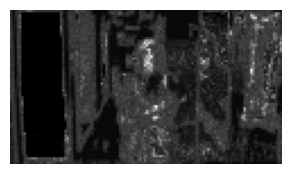

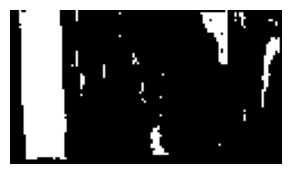

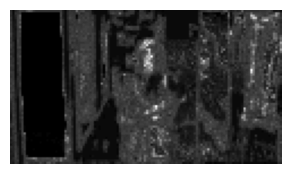

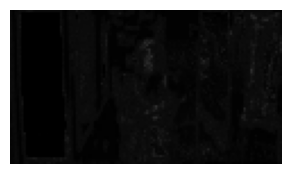

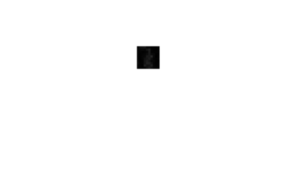

In [385]:
show_np_size(a[1])
print(a[1].shape)
show_np_size(a[2])
print(a[1][0,0])

gray_img = a[1].astype(np.uint8)
show_np_size(gray_img)

# 칼라 이미지로 변환
img_color = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
show_np_size(img_color)
temp_masked = gray_img.copy()

temp_face = cv2.resize(standard_face, [a[1].shape[1],a[1].shape[0]])
print(temp_face.shape)

temp_masked[np.where(temp_face[:,:,0] == 0)] = 255
show_np_size(temp_masked)

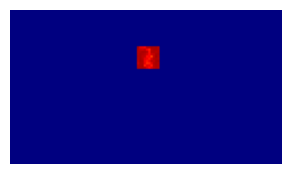

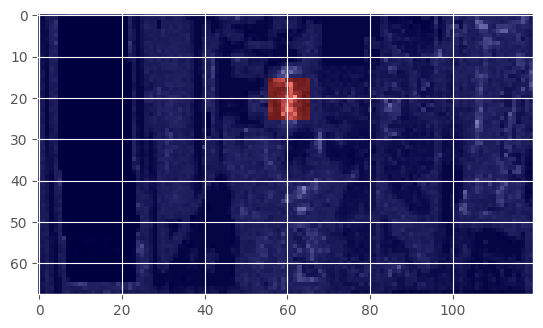

In [386]:

# 히트맵 생성
heatmap = cv2.applyColorMap(temp_masked, cv2.COLORMAP_JET)
show_np_size(heatmap)
# 원래 이미지와 히트맵 결합
# 히트맵과 흑백 이미지를 함께 그리기
fig, ax = plt.subplots()
ax.imshow(gray_img, cmap='gray')
ax.imshow(heatmap, cmap='jet', alpha=0.5)
plt.show()

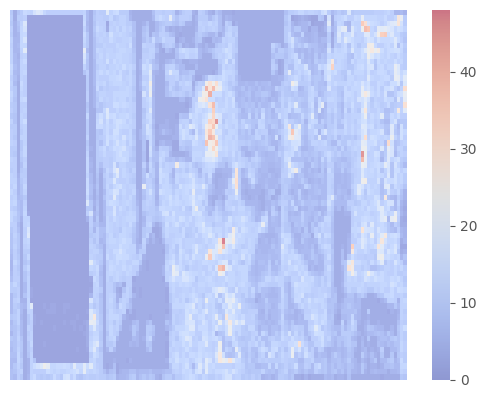

In [394]:
import seaborn as sns
# 히트맵 생성 temp_masked heatmap
heatmap_data = np.random.rand(heatmap.shape[0], temp_masked.shape[1]) # 임의의 데이터 생성
sns.heatmap(gray_img, cmap='coolwarm', alpha=0.5)

# 흑백 이미지와 히트맵을 겹쳐서 출력
# plt.imshow(temp_masked, cmap='gray')
plt.axis('off')
plt.show()

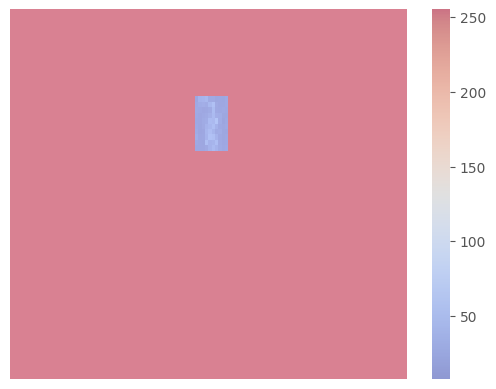

In [395]:
sns.heatmap(temp_masked, cmap='coolwarm', alpha=0.5)

# 흑백 이미지와 히트맵을 겹쳐서 출력
# plt.imshow(temp_masked, cmap='gray')
plt.axis('off')
plt.show()

- Stastics computing
- Mahalanobis distances

In [197]:
suspect_area = fc_orientation_map.copy()
suspect_features = []
grid_size = 8
height, width = suspect_area.shape[:2]
print(suspect_area.shape)

for i in range(grid_size, min(height, width), grid_size):
    tmp = []
    for j in range(grid_size, min(height, width), grid_size):
        roi = suspect_area[i-grid_size:i+grid_size, j-grid_size:j+grid_size, :]
        feature = np.mean(cv2.dct(cv2.cvtColor(roi.astype(np.float32), cv2.COLOR_BGR2GRAY)).ravel())
        tmp.append(feature)
    suspect_features.append(tmp)
suspect_features = np.array(suspect_features)
print(suspect_features.shape)

(1080, 1920, 3)
(134, 134)


In [192]:
reterence_area = bg_orientation_map.copy()
reterence_features = []
height, width = suspect_area.shape[:2]
print(suspect_area.shape)

for i in range(grid_size, min(height, width), grid_size):
    tmp = []
    for j in range(grid_size, min(height, width), grid_size):
        roi = reterence_area[i-grid_size:i+grid_size, j-grid_size:j+grid_size, :]
        feature = np.mean(cv2.dct(cv2.cvtColor(roi.astype(np.float32), cv2.COLOR_BGR2GRAY)).ravel())
        tmp.append(feature)
    reterence_features.append(tmp)
reterence_features = np.array(reterence_features)
# print(reterence_features)
print(reterence_features.shape)

(1080, 1920, 3)
(134, 134)


In [284]:
reference_mean = np.mean(reterence_features)
reference_covariance = np.cov(reterence_features)

(134, 134)
382.6628474814271
(134, 134)
798.9541660769718


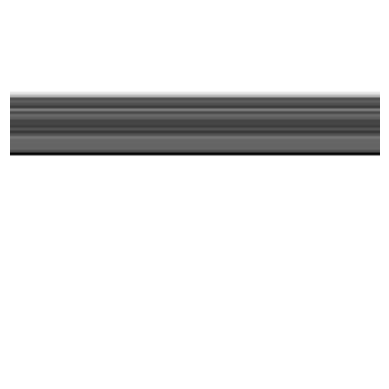

In [238]:
from scipy.spatial.distance import mahalanobis

# Calculate mean and covariance matrix of reference features

ref_mean = np.mean(reterence_features, axis=0)
ref_cov = np.cov(reterence_features)#, rowvar=False)#.transpose()
print(ref_cov.shape)
inv_cov = np.linalg.inv(ref_cov)
# reference_mean = np.mean(reterence_features)
# reference_covariance = np.cov(reterence_features)

# Check the shape of the covariance matrix

# if ref_cov.ndim != 2:
#     raise ValueError("Reference covariance matrix has incorrect shape")
# mahalanobis distance 계산
# maha_dist = mahalanobis(u, v, np.linalg.inv(cov))
distances = []
for feature_vector in reterence_features:
    distance = mahalanobis(feature_vector, ref_mean, ref_cov)
    distances.append(distance)
    

# Calculate 99th percentile of Mahalanobis distances as manipulation score

manipulation_score = np.percentile(distances, 99)
print(manipulation_score)

distances = []
for feature_vector in suspect_features:
    d_temp = []
    for i in feature_vector:
        distance = mahalanobis(feature_vector, ref_mean, ref_cov)
        d_temp.append(distance)
    distances.append(d_temp)
print(np.array(distances).shape)
show_np(np.array(distances))
# Calculate 99th percentile of Mahalanobis distances as manipulation score

manipulation_score = np.percentile(distances, 99)
print(manipulation_score)

In [226]:
# Calculate the Mahalanobis distance between the reference and suspect features

# inv_cov = np.linalg.inv(ref_cov)
# distances = []
# for feat in suspect_features:
#     diff = feat - ref_mean
#     dist = np.sqrt(diff.T @ ref_cov @ diff)
#     distances.append(dist)

# Calculate the final heat map

threshold = np.percentile(distances, 99)
print(threshold)

heat_map = np.zeros_like(suspect_features).reshape(suspect_features.shape[0], suspect_features.shape[1], 1)
heat_map = np.array(distances)
heat_map[heat_map < int(threshold)] = 0
print(heat_map.shape)

798.9541660769718
(134, 134)


In [239]:
print(np.array(distances))

[[798.95416608 798.95416608 798.95416608 ... 798.95416608 798.95416608
  798.95416608]
 [798.95416608 798.95416608 798.95416608 ... 798.95416608 798.95416608
  798.95416608]
 [798.95416608 798.95416608 798.95416608 ... 798.95416608 798.95416608
  798.95416608]
 ...
 [798.95416608 798.95416608 798.95416608 ... 798.95416608 798.95416608
  798.95416608]
 [798.95416608 798.95416608 798.95416608 ... 798.95416608 798.95416608
  798.95416608]
 [798.95416608 798.95416608 798.95416608 ... 798.95416608 798.95416608
  798.95416608]]


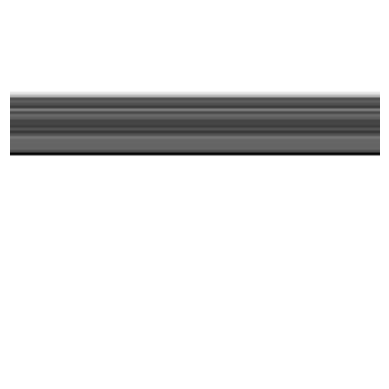

In [237]:
distances = np.array(distances)
# distances *= (255.0/distances.max())
distances = (distances-np.min(distances))/(np.max(distances)-np.min(distances))
show_np(distances)